### Machine Learning Audio Classification MEL ResNet-32
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset used readup)


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)

# are we resuming training?
resume = False

2.7.0
Num GPUs Available:  1


2022-02-01 14:12:47.221904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 14:12:47.263106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 14:12:47.263411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Core ResNet Structures
A ResNet can be called an upgraded version of the VGG architecture, with the difference between them being the skip connections used in ResNets. In the figure below, we can see the architecture of the VGG as well as the 34 layer ResNet.



In [3]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

### MFCC FEATURE READ IN
In this section we will read in our kaggle 2018 dataset which have already been featured extracted and normalized

In [2]:
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load the training data
dataset_train_folder = os.path.join(dataset_root_dir, 'train')
dataset_train_csv = os.path.join(dataset_train_folder, 'catalog.csv')
model_dir = os.path.join( dataset_root_dir, 'models')

In [3]:

# load in our data_frame
metadata = pd.read_csv(dataset_train_csv)

# Pre-processed MFCC coefficients
X = np.load( os.path.join(data_npy_folder, "X-mel-spec.npy" ) )
y = np.load( os.path.join(data_npy_folder, "y-mel-spec.npy" ) )


In [4]:
# create train and test sets
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1894 		 Train split: 7579
X test shape: (1894, 40, 2584) 	 X train shape: (7579, 40, 2584)
y test shape: (1894,) 		 y train shape: (7579,)


### visualize the label count distribution for train and test data

#### train label count distribution

<BarContainer object of 41 artists>

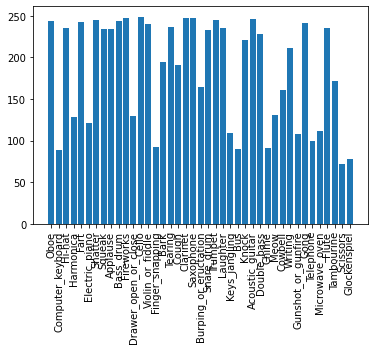

In [7]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

#### test label count distribution

<BarContainer object of 41 artists>

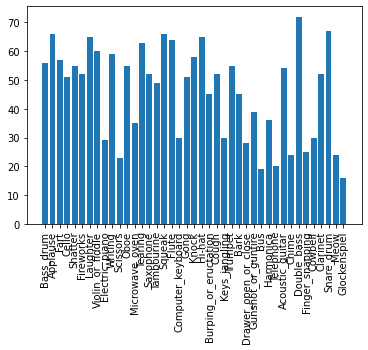

In [8]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

In [5]:
# encode the labels to categorical
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [6]:
y_test[2], y_test_encoded[2]

('Fart',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [7]:
# How data should be structured
num_rows = 40
num_columns = 2584 
num_channels = 1

# Reshape to fit the network input (channel last)

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
num_labels

41

In [12]:
# create the input shape of the neural network
input_shape = (num_rows, num_columns, num_channels)

if resume is False: # if we are not resuming from a previous model
    model = ResNet34(input_shape, num_labels) # create the model

2022-02-01 12:33:57.360745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 12:33:57.362841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 12:33:57.363507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 12:33:57.364011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [13]:

# TODO: source of this model was made from https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/
# TODO: this may be useful charles for learning rates justification https://arxiv.org/pdf/1908.06477.pdf
# 2. compile the model
if resume is False:
    learing_rate = 0.000005
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 500 # standard we are training for 500 epochs
    num_batch_size = 32 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance

    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

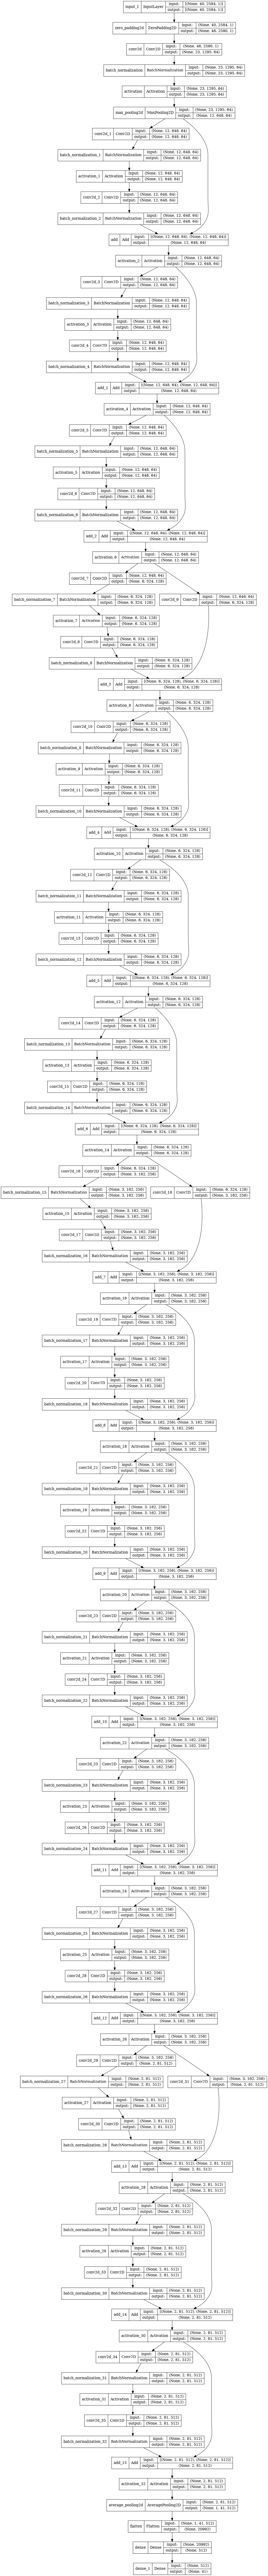

In [14]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [15]:
# modelplot = ModelPlot(model=model, grid=True, connection=False, linewidth=0.1)
# modelplot.show()
#model_dir = os.path.join( dataset_root_dir, 'models')
# get the directory of the model output
if resume is False:
    model_path = os.path.join(model_dir, f'K2018_MELSPEC_RESNET32_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_categorical_crossentropy.h5')
else:
    num_epochs = 250
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'n/a')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MELSPEC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_categorical_crossentropy.h5'

In [16]:

# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_split=1/12.,
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

# history = model.fit(
#     X_train,
#     y_train_encoded,
#     epochs=250,
#     verbose=1,
#     callbacks=[early_stopping_callback, checkpointer],
#     validation_data=(X_test, y_test_encoded)
# )

end = datetime.now() - start
print("Training time: {}".format(end))

2022-02-01 12:36:45.212274: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.
2022-02-01 12:36:46.768991: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.


Epoch 1/500


2022-02-01 12:36:51.421231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


218/218 [==============================] - ETA: 0s - loss: 3.5349 - accuracy: 0.1258
Epoch 00001: val_loss improved from inf to 3.78876, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MELSPEC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_categorical_crossentropy.h5


/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


218/218 [==============================] - 86s 374ms/step - loss: 3.5349 - accuracy: 0.1258 - val_loss: 3.7888 - val_accuracy: 0.0332
Epoch 2/500
218/218 [==============================] - ETA: 0s - loss: 2.8223 - accuracy: 0.2552
Epoch 00002: val_loss improved from 3.78876 to 3.77442, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MELSPEC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_categorical_crossentropy.h5
218/218 [==============================] - 83s 383ms/step - loss: 2.8223 - accuracy: 0.2552 - val_loss: 3.7744 - val_accuracy: 0.0491
Epoch 3/500
218/218 [==============================] - ETA: 0s - loss: 2.4589 - accuracy: 0.3462
Epoch 00003: val_loss improved from 3.77442 to 3.01133, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MELSPEC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_categorical_crossentropy.h5
218/218 [==============================] - 81s 372ms/step - loss: 2.4589 - accuracy: 0

KeyboardInterrupt: 

In [17]:
helper.plot_train_history(history, x_ticks_vertical=True)

NameError: name 'history' is not defined

Text(0.5, 0, 'epochs')

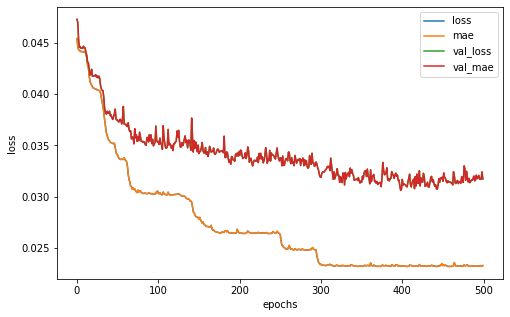

In [27]:
# plot history also known as loss curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [8]:
model_path = os.path.join(model_dir, 'K2018_MELSPEC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_categorical_crossentropy_50%.h5')

# Load best saved model
model = load_model(model_path)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# test_score = model.evaluate(X_test, y_test, verbose=0)
# test_score
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     #train_score = model.evaluate(X_train, y_train, verbose=0)
#     test_score = model.evaluate(X_test, y_test, verbose=0)
#     return test_score#train_score, test_score


# def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
#     dash = '-' * 38

#     # Compute scores
#     train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

#     # Pint Train vs Test report
#     print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
#     print(dash)
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


#     # Calculate and report normalized error difference?
#     if (calc_normal):
#         max_err = max(train_score[0], test_score[0])
#         error_diff = max_err - min(train_score[0], test_score[0])
#         normal_diff = error_diff * 100 / max_err
#         print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

#length = len(a_list)

#model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)


2022-02-01 14:13:07.208504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 14:13:07.209992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 14:13:07.210251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 14:13:07.210455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:

model.metrics_names

['loss', 'accuracy']

ValueError: The number of FixedLocator locations (41), usually from a call to set_ticks, does not match the number of ticklabels (1894).

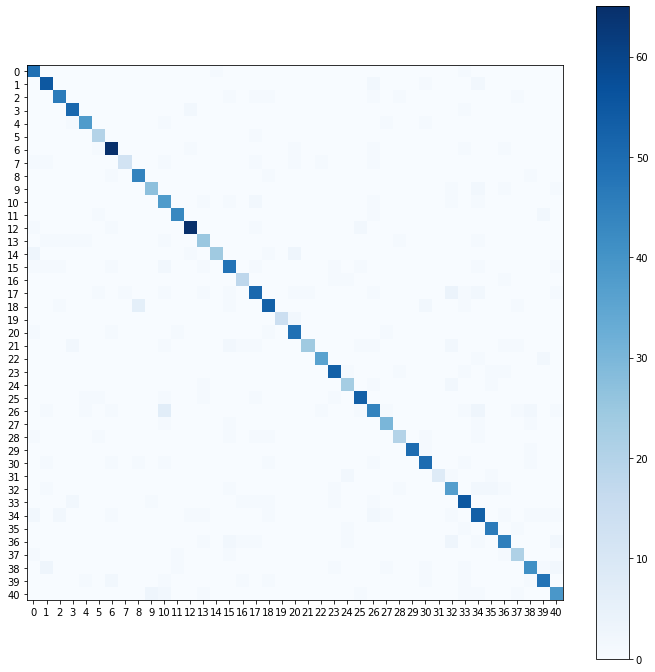

In [10]:
importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm,
    y_test, 
    normalized=False, 
    title="Model Performance", 
    cmap=plt.cm.Blues,
    size=(12,12))

In [11]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2022-02-01 14:13:31.238172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3133461760 exceeds 10% of free system memory.
2022-02-01 14:13:32.759341: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3133461760 exceeds 10% of free system memory.


60/60 [==============================] - 7s 108ms/step - loss: 0.6411 - accuracy: 0.8506
                    LOSS      ACCURACY
--------------------------------------
Training:         0.5520       86.4362
Test:             0.6411       85.0581
Normal diff         13.89 
